# Compare G4 odor, forward walking velocity, and wind direction filters between high- and low- air flow conditions

In [1]:
%matplotlib inline
from copy import deepcopy
from itertools import product as cproduct
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, Ridge

from aux import Generic
from data import DataLoader, random_chunk_split
from db import make_session, d_models
from lin_fit import fit_h_train_test, calc_r2
from plot import set_font_size, unity_line

import CONFIG as C

In [2]:
TRAIN_LEN = 1  # s
TEST_LEN = 0  # s

WDW = (-3, 1)

METHOD = 'built-in'
PARAMS = {
    'v_fwd': {'model': LinearRegression},
    'odor_binary': {'model': LinearRegression},
    'w_air': {'model': lambda: Lasso(alpha=0.5)},
    'air': {'model': LinearRegression},
}

BINS_AIR = np.linspace(-180, 180, 73)
MAX_AIR = 90

Linear models

In [3]:
class ModelVFS(object):
    
    name = 'VFS'
    
    x_names = ['v_fwd']
    y_name = 'g4s'
    normed = True
    
    def __init__(self, trial):
        
        # run odor_binary --> g4s fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            wdws={'v_fwd': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['v_fwd'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [4]:
class ModelOS(object):
    
    name = 'OS'
    
    x_names = ['odor_binary']
    y_name = 'g4s'
    normed = True
    
    def __init__(self, trial):
        
        # run odor_binary --> g4s fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [5]:
class ModelOR(object):
    
    name = 'OR'
    
    x_names = ['odor_binary']
    y_name = 'g4r'
    normed=True
    
    def __init__(self, trial):
        
        # run odor_binary --> g4r fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [6]:
class ModelOL(object):
    
    name = 'OL'
    
    x_names = ['odor_binary']
    y_name = 'g4l'
    normed = True
    
    def __init__(self, trial):
        
        # run odor_binary --> g4l fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            wdws={'odor_binary': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['odor_binary'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [7]:
class ModelW(object):
    
    name = 'W'
    
    x_names = ['w_air']
    y_name = 'g4d'
    
    normed = False
    
    def __init__(self, trial):
        
        # run w_air --> g4d fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            wdws={'w_air': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['w_air'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [8]:
class ModelA(object):
    
    name = 'A'
    
    x_names = ['air']
    y_name = 'g4d'
    
    normed = False
    
    def __init__(self, trial):
        
        # run air --> g4d fit
        self.rslt = fit_h_train_test(
            trial=trial,
            x_names=self.x_names,
            y_name=self.y_name,
            wdws={'air': WDW},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHOD,
            params=PARAMS['air'],
            normed=self.normed,
            C=C,
            allow_nans=True)

In [9]:
MODEL_CLASSES = [ModelVFS, ModelOS, ModelOR, ModelOL, ModelW, ModelA]
MODEL_DICT = {model_class.name: model_class for model_class in MODEL_CLASSES}

# Define key functions

In [10]:
def load_trials(region, expt, skip=None):
    
    if skip is None:
        skip = []
        
    # load trials
    session = make_session()
    trials = session.query(d_models.Trial).filter(
        d_models.Trial.region == region, d_models.Trial.expt == expt).all()
    trials = [trial for trial in trials if trial.name not in skip]
    session.close()

    # load data and create a moving average 
    for trial in trials:
        trial.dl = DataLoader(trial, 0, None)

        # nan out air and w_air for times when air is past threshold
        mask = np.abs(trial.dl.air) < MAX_AIR

        air, w_air = trial.dl.air, trial.dl.w_air

        air[~mask] = np.nan
        w_air[~mask] = np.nan

        trial.dl.data['AIR'] = air
        trial.dl.data['W_AIR'] = w_air
        
    return trials

In [11]:
def plot_air(trials):
    
    airs = np.concatenate([trial.dl.air for trial in trials])

    fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
    ax.hist(airs[~np.isnan(airs)], bins=BINS_AIR)

    ax.set_xlabel('Air tube position (deg)')
    ax.set_ylabel('Counts')

    set_font_size(ax, 16)

In [12]:
def fit_models(trials):

    models = {}

    for model_class in MODEL_CLASSES:

        models_ = {trial.name: model_class(trial) for trial in trials}
        models[model_class.name] = models_
        
    return models

In [13]:
def plot_y_vs_y_hat(trials, models):
    
    ax_h = 3
    
    ax_grid = (len(trials), len(models))

    fig_size = (20, ax_h*ax_grid[0])

    fig, axs = plt.subplots(*ax_grid, figsize=fig_size, tight_layout=True)

    r2s_train = {model_class.name: [] for model_class in MODEL_CLASSES}

    for trial, ax_row in zip(trials, axs):
        for model_class, ax in zip(MODEL_CLASSES, ax_row):

            model = models[model_class.name][trial.name]

            y = model.rslt.y
            y_hat_train = model.rslt.y_hat_train
            y_hat_test = model.rslt.y_hat_test
            r2_train = model.rslt.r2_train

            ax.scatter(y_hat_train, y, lw=0, c='gray', s=1)
            ax.scatter(y_hat_test, y, lw=0, c='k', s=8)

            unity_line(ax, *ax.get_xlim(), ls='--', zorder=-1)

            ax.grid()

            ax.set_title('{0}\n({1})\nR2 = {2:.4f}'.format(trial.name, model.name, r2_train))

            r2s_train[model_class.name].append(r2_train)

    for ax in axs.flatten():
        ax.set_xlabel('y_hat')
        ax.set_ylabel('y')
        set_font_size(ax, 16)
        
    return r2s_train

In [14]:
def plot_r2_scatters(r2s_train):
    
    fig, axs = plt.subplots(1, len(R2_SCATTERS), figsize=(15, 5), tight_layout=True, squeeze=False)
    axs = axs[0]

    for r2_scatter, ax in zip(R2_SCATTERS, axs):
        r2_x = r2s_train[r2_scatter[0]]
        r2_y = r2s_train[r2_scatter[1]]

        x_label = 'R2({})'.format(r2_scatter[2])
        y_label = 'R2({})'.format(r2_scatter[3])

        ax.scatter(r2_x, r2_y, c='k', lw=0)

        ax.set_xlim(-0.2, 0.8)
        ax.set_ylim(-0.2, 0.8)

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        set_font_size(ax, 16)

In [15]:
def plot_r2s_bar(trials, models):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

    r2_mdns = []
    r2_stds = []

    for model_class in MODEL_CLASSES:

        r2s = []

        for trial in trials:
            model = models[model_class.name][trial.name]

            r2 = model.rslt.r2_train

            r2s.append(r2)

        r2_mdns.append(np.nanmedian(r2s))
        r2_stds.append(np.nanstd(r2s))

    x_bar = np.arange(len(r2_mdns))
    x_ticks = x_bar
    x_tick_labels = [model_class.name for model_class in MODEL_CLASSES]

    ax.bar(x_bar, r2_mdns, yerr=r2_stds, align='center')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

    ax.axhline(0, color='gray', ls='--')
    ax.axvline(3.5, color='r', lw=2)

    ax.set_ylim(0, 1)
    
    ax.grid()

    ax.set_xlabel('Model Class')
    ax.set_ylabel('R2')

    set_font_size(ax, 16)

In [16]:
def plot_filters(trials, models):
    
    ax_h = 3.5
    
    ax_grid = (len(trials) + 1, len(models))
    
    fig_size = (20, ax_h*ax_grid[0])

    y_lims = {
        'VFS': (-0.2, 0.2),
        'OS': (-0.2, 0.2),
        'OR': (-0.2, 0.2),
        'OL': (-0.2, 0.2),
        'W': (-0.004, 0.0015),
        'A': (-0.01, 0.01),
    }

    fig, axs = plt.subplots(*ax_grid, figsize=fig_size, tight_layout=True)

    labels = [mc.name for mc in MODEL_CLASSES]

    t_hs = {label: [] for label in labels}
    hs = {label: [] for label in labels}
    icpts = {label: [] for label in labels}

    # plot individual trial filters
    for trial, ax_row in zip(trials, axs):
        for ctr, ax in enumerate(ax_row):

            label = labels[ctr]
            model = models[label][trial.name]
            t_h = model.rslt.t_hs[model.rslt.x_names[0]]
            h = model.rslt.hs[model.rslt.x_names[0]]
            icpt = model.rslt.icpt

            ax.plot(t_h, h, lw=2, c='k')
            ax.set_title('{}\n{}'.format(trial.name, label))

            t_hs[label].append(t_h)
            hs[label].append(h)
            icpts[label].append(icpt)

    # plot mean filters
    t_hs_mdn = {label: np.nanmedian(t_hs[label], 0) for label in labels}
    hs_mdn = {label: np.nanmedian(hs[label], 0) for label in labels}
    icpts_mdn = {label: np.nanmedian(icpts[label], 0) for label in labels}

    for label, ax in zip(labels, axs[-1, :]):

        ax.axhline(0, c='r', lw=2)
        ax.axvline(0, c='r', lw=2)

        ax.plot(t_hs_mdn[label], np.array(hs[label]).T, lw=0.5, color='gray')
        ax.plot(t_hs_mdn[label], hs_mdn[label], lw=3, color='k')

        ax.set_ylim(y_lims[label])

        ax.set_title(label)

    for ax in axs.flatten():

        ax.grid()

        ax.set_xlabel('t (s)')
        ax.set_ylabel('h')

        set_font_size(ax, 16)
        
    return fig, hs_mdn, icpts_mdn

# Plot truth vs predicted G4X for each trial/model

In [17]:
R2_SCATTERS = [
    ('VFS', 'OS', 'v_fwd->g4s', 'odor->g4s'),
    ('OS', 'W', 'odor->g4s', 'w_air->g4d'),
    ('VFS', 'W', 'v_fwd->g4s', 'w_air->g4d'),
]

### White noise trials with low air flow

In [18]:
trials = load_trials('dan', 'white_odor_fluct_lowflow')

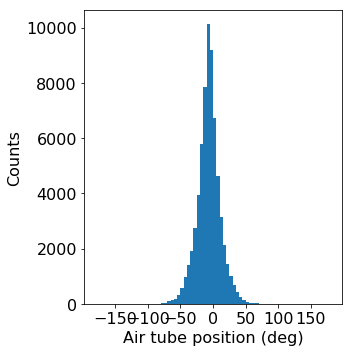

In [19]:
plot_air(trials)

In [20]:
models = fit_models(trials)

Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/t

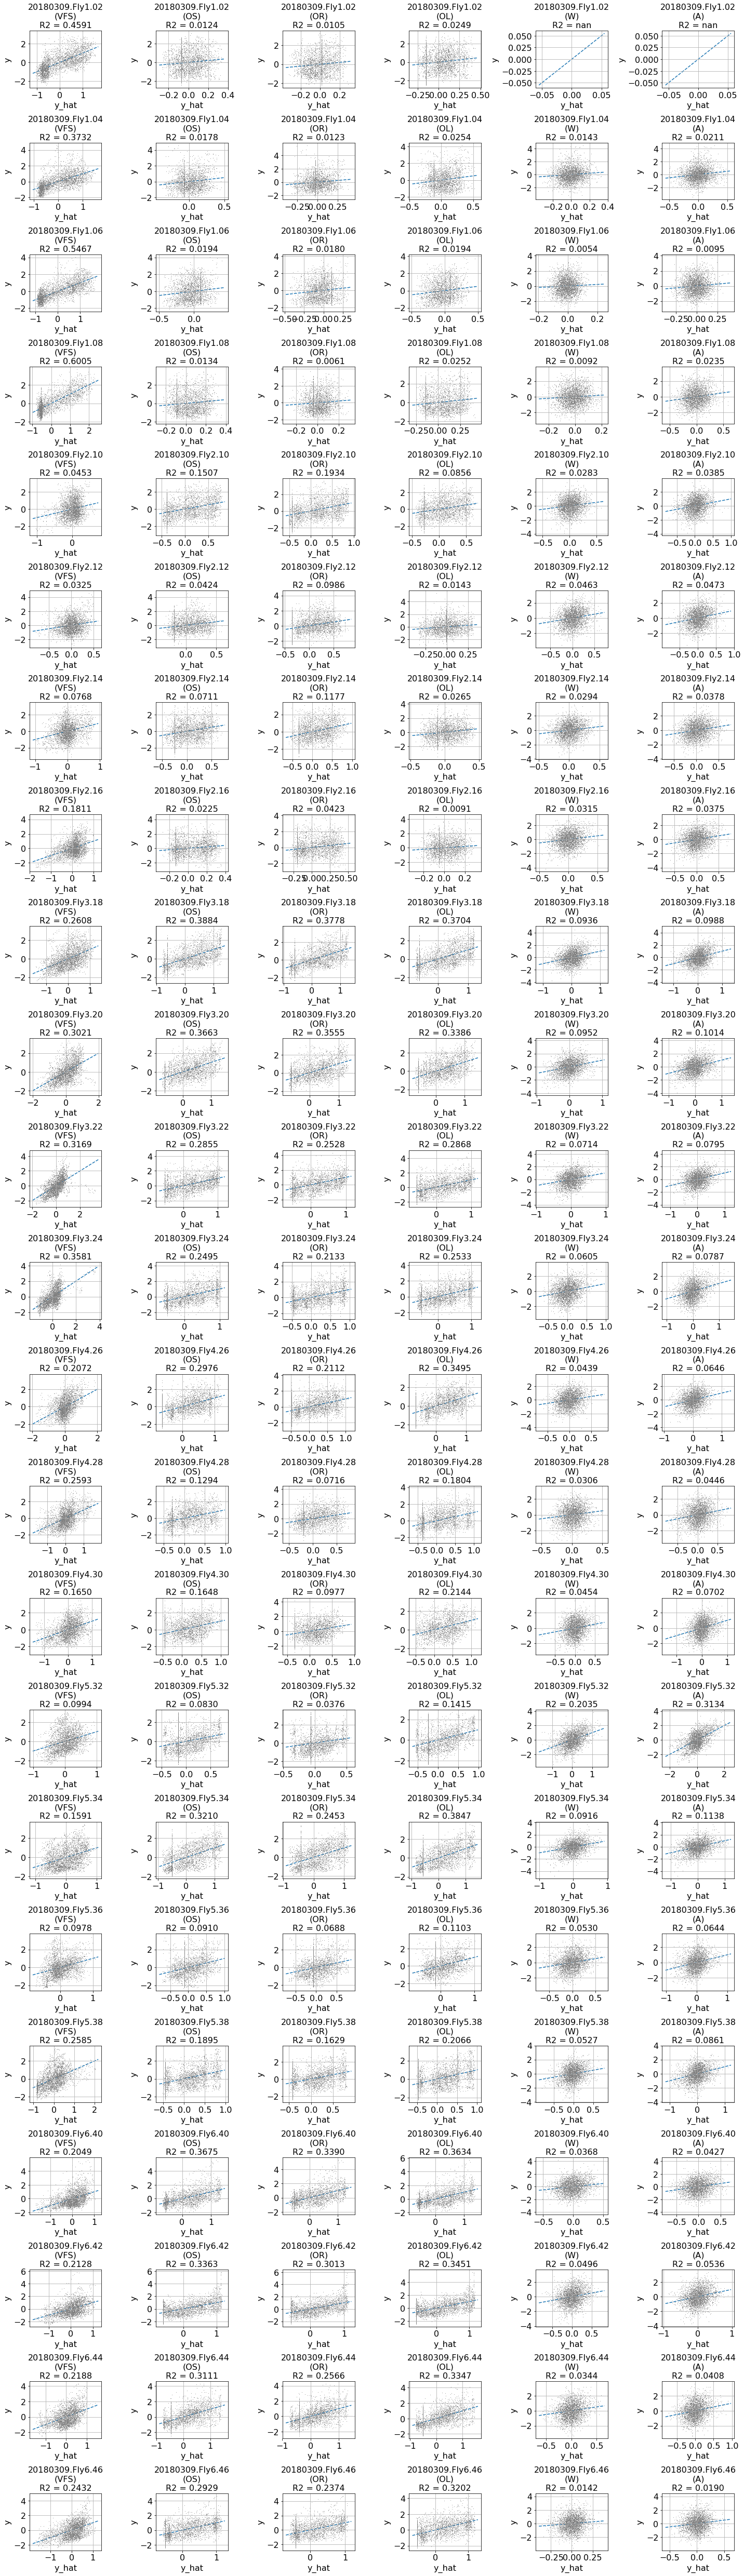

In [21]:
r2s_train = plot_y_vs_y_hat(trials, models)

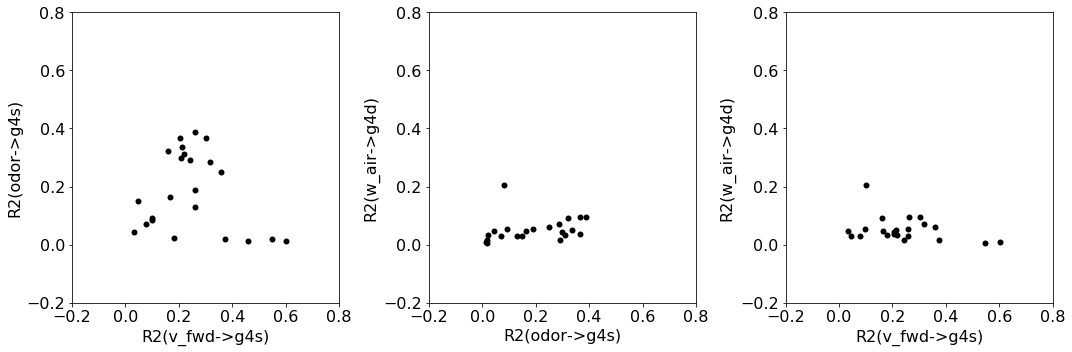

In [22]:
plot_r2_scatters(r2s_train)

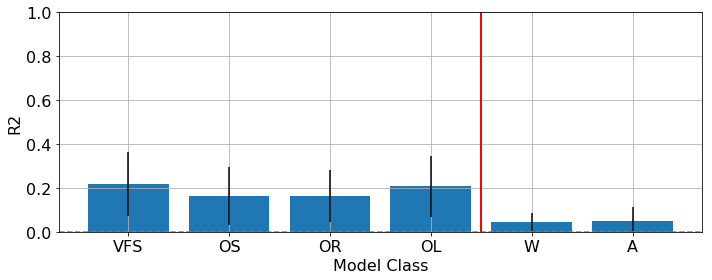

In [23]:
plot_r2s_bar(trials, models)

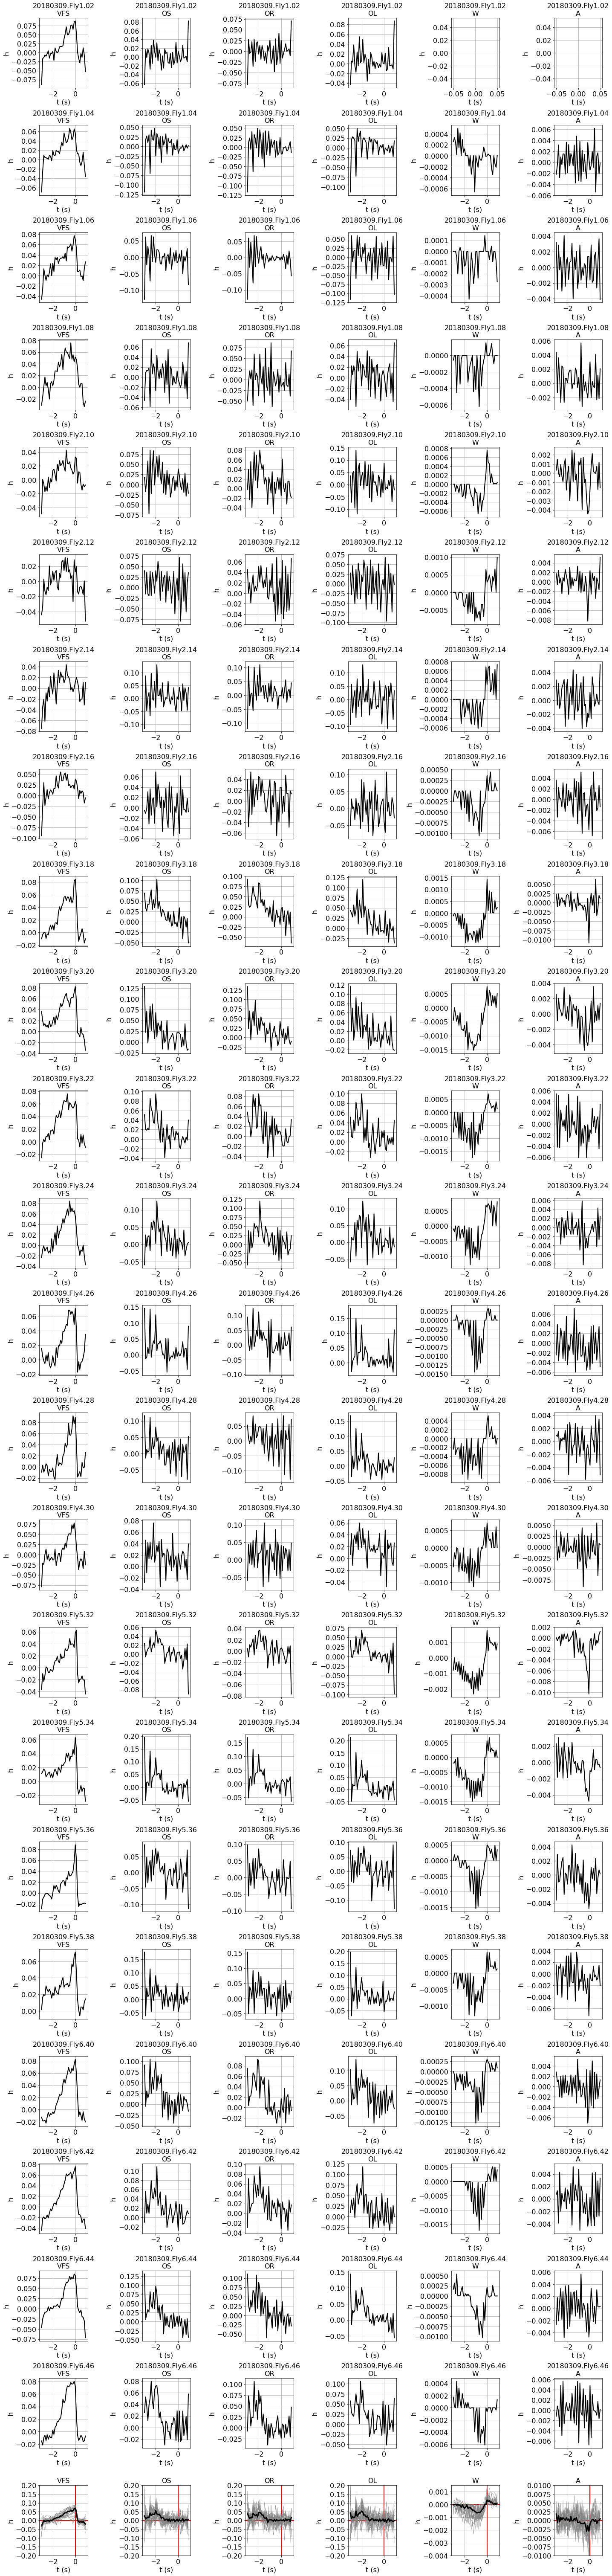

In [24]:
fig_w, hs_mdn_w, icpts_mdn_w = plot_filters(trials, models)
fig_w.savefig('filters_dan_white_odor_fluct_lowflow.png', dpi=300)

### White noise trials with high air flow

In [25]:
trials = load_trials('dan', 'white_odor_fluct_highflow')

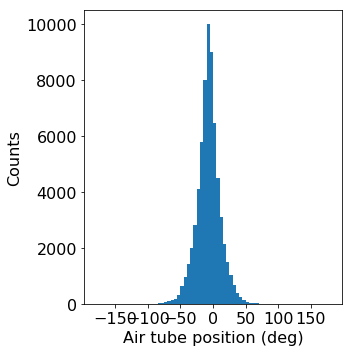

In [26]:
plot_air(trials)

In [27]:
models = fit_models(trials)

Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/training data.
Not splitting into test/t

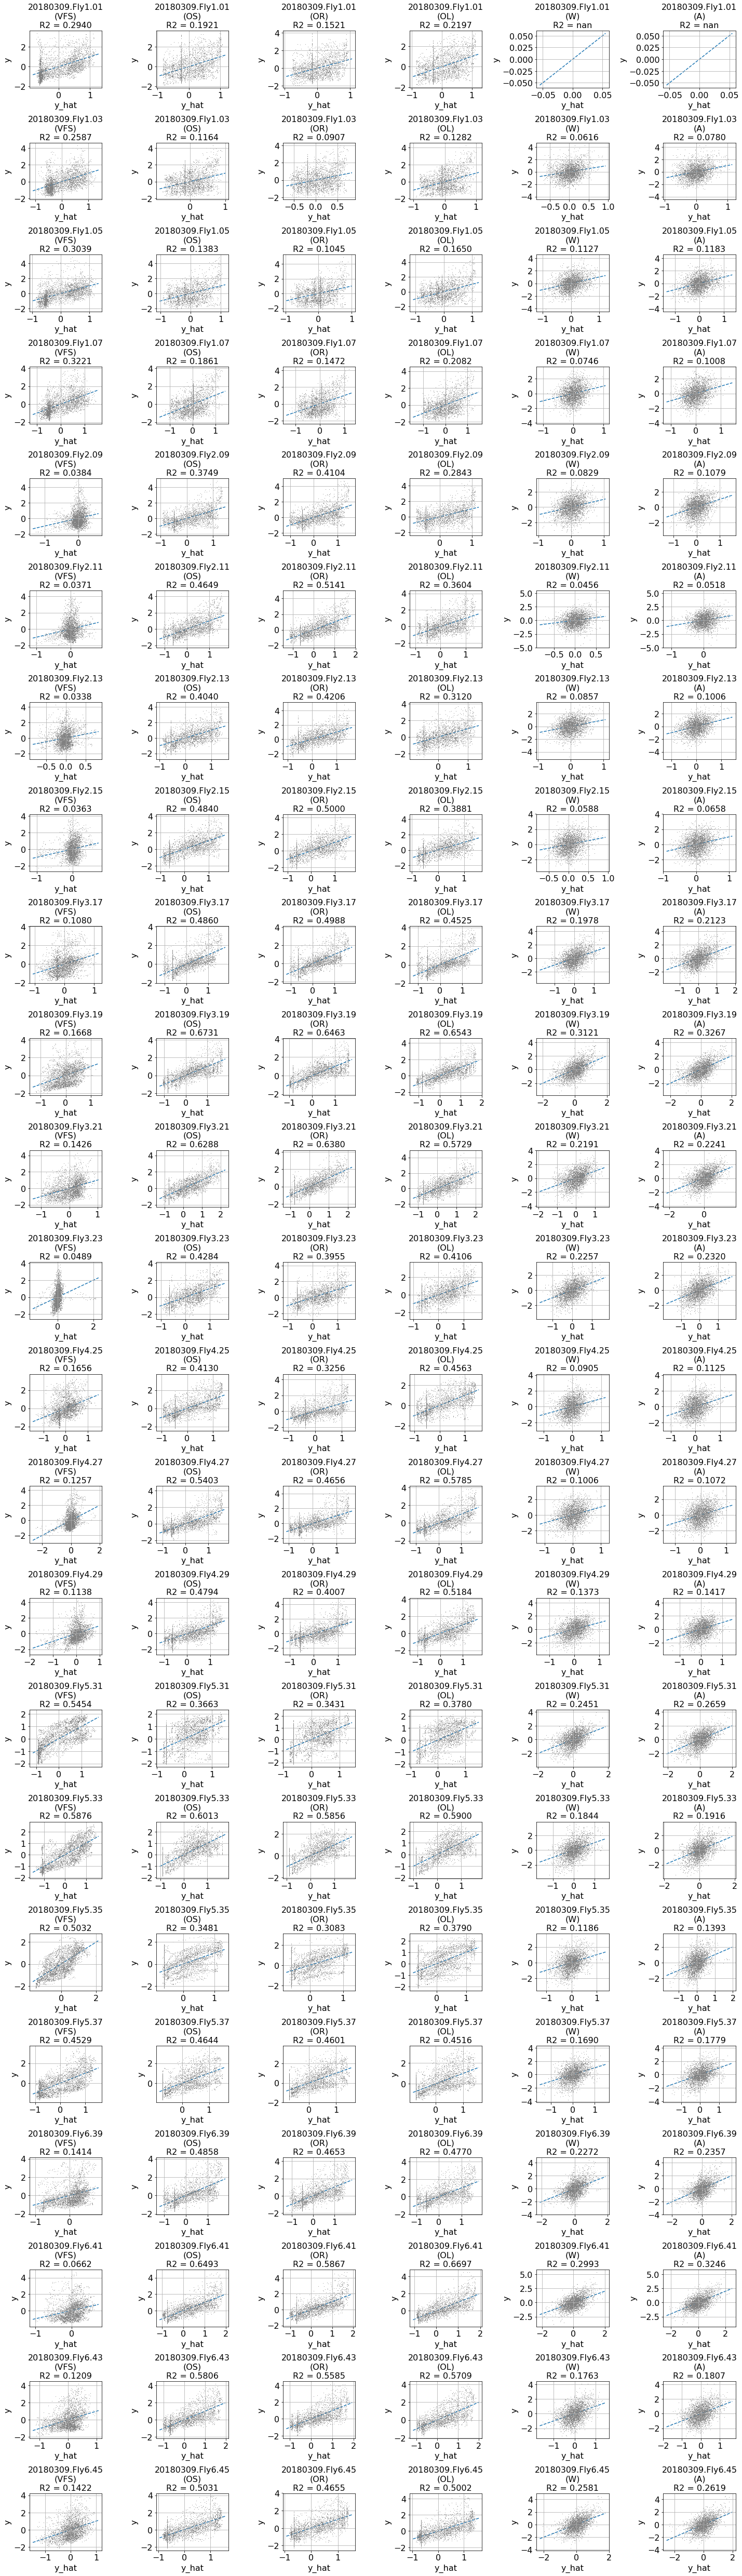

In [28]:
r2s_train = plot_y_vs_y_hat(trials, models)

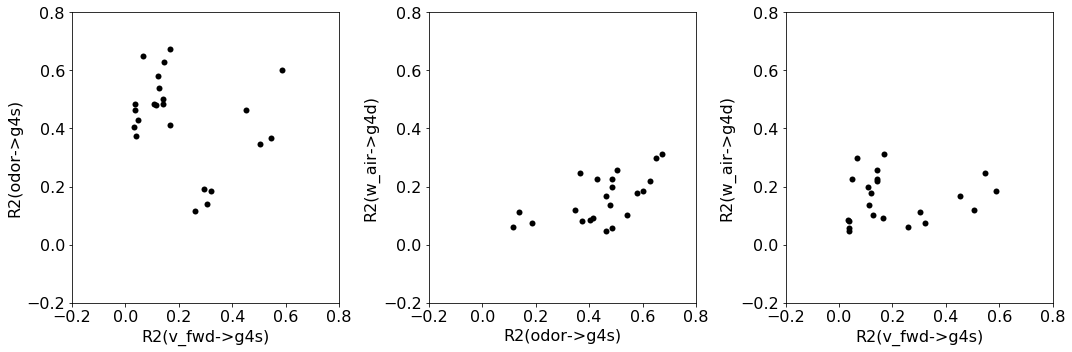

In [29]:
plot_r2_scatters(r2s_train)

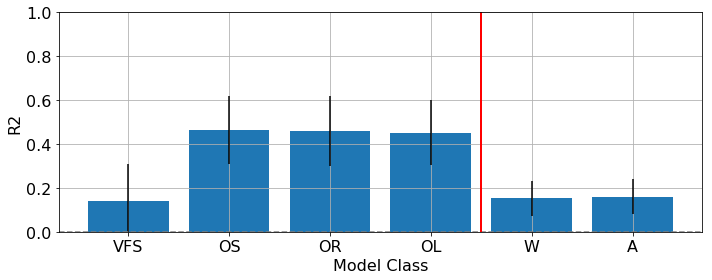

In [30]:
plot_r2s_bar(trials, models)

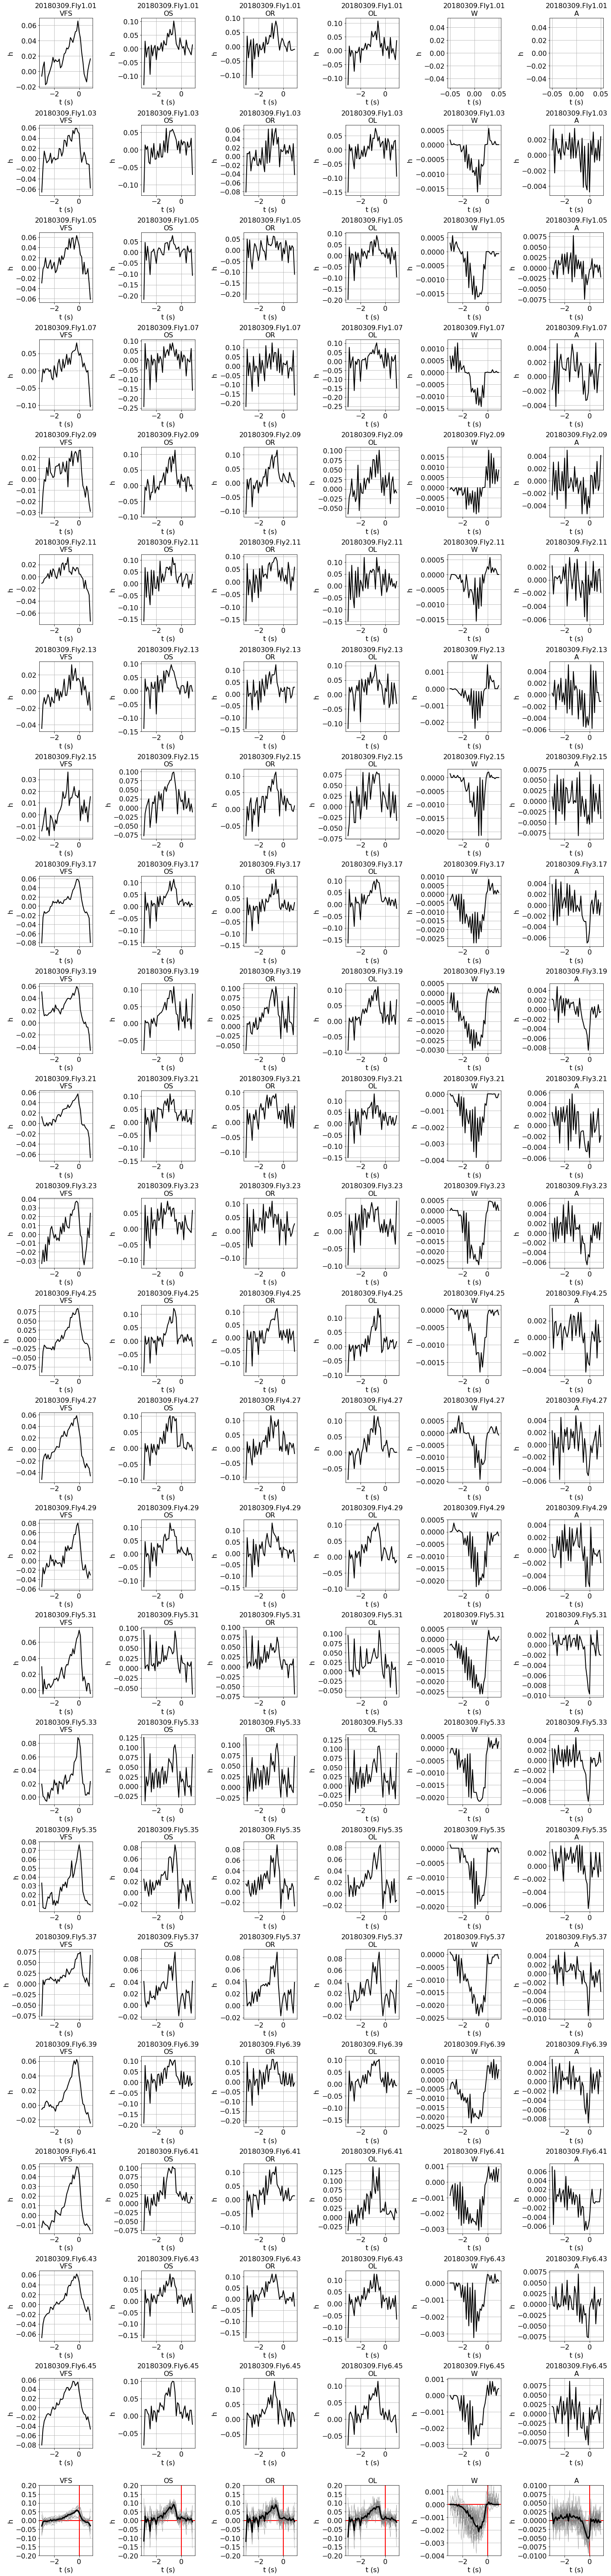

In [31]:
fig_w, hs_mdn_w, icpts_mdn_w = plot_filters(trials, models)
fig_w.savefig('filters_dan_white_odor_fluct_highflow.png', dpi=300)